In [1]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sympy.solvers import solve
from sympy import Symbol
import os
import numpy as np 
PI= np.pi
import random
import math
from PIL import Image
from PIL import ImageColor

In [2]:
def read_txt(file_path):
    f=open(file_path)
    f.readline()
    xl=[]
    yl=[]
    for n in range(9): 
        lx=f.readline()
        lx=lx.rstrip() 
        lx=lx.split("\t")
        xl.append(float(lx[0]))
        yl.append(float(lx[1]))
        #xl.append(float(lx[0]) 
        #yl.append(float(lx[1])
    return np.array([xl,yl])
def rotatexyz(x,y,z): 
    # xyx rotate angle 
    rotatex=[[1,0,0],[0,np.cos(x),-np.sin(x)],[0,np.sin(x),np.cos(x)]]
    rotatey=[[np.cos(y),0,np.sin(y)],[0,1,0],[-np.sin(y),0,np.cos(y)]]
    rotatez=[[np.cos(z),-np.sin(z),0],[np.sin(z),np.cos(z),0],[0,0,1]]
    temp=np.dot(rotatez,rotatey)
    return np.dot(temp,rotatex)
def make_mimic_data_3d(rx,ry,rz,d1,h1,theta,n,c1,c2): 
    rotation_matrix=rotatexyz(rx,ry,rz)
    u = np.linspace(0, 2 * np.pi, n,endpoint=False) + theta* PI
    
    x1 = d1 * (np.sin(u)) + c1
    y1 = d1 * (np.cos(u)) + c2
    z1 = h1  *  np.ones(x1.shape) 
    data_stack=np.vstack([x1,y1,z1])
    mic_data = np.dot(rotation_matrix,data_stack)
    return [data_stack,mic_data]

def make_ratio_and_angle():
    answ_dict={}

    for idxx in range(180):
        for idxy  in  range(180):
            zr=0
                
            data,mic_data_3d=make_mimic_data_3d((idxx*PI)/180,(idxy*PI)/180,0,1,0,0,180,0,0)
            mic_data=mic_data_3d[:2]
            max_idx=0
            min_idx=0
            max_num=-np.inf
            min_nim=np.inf
            for i in range(0,mic_data.shape[1]//2):
                d_data=mic_data[:,i]-mic_data[:,i+90]
                dx=np.sqrt(sum(d_data*d_data))
                if dx > max_num:
                    max_idx=i
                    max_num=dx
                elif dx < min_nim:
                    min_idx=i
                    min_nim=dx
            r_min=mic_data[1][min_idx]/(mic_data[0][min_idx])
            r_max=mic_data[1][max_idx]/(mic_data[0][max_idx])
            answ_want=[round(max_num,2),round(min_nim,2),round(r_max,2),round(r_min,2)]
            answ_dict[(idxx,idxy)]=answ_want
    return answ_dict

def solve_tuoyuan(x,y):
    #a*x**2 + b*x*y + c*y**2 + d*x + e*y + f
    print('拟合......')
    x0,y0 = x.mean(),y.mean()      
    D1=np.array([(x-x0)**2,(x-x0)*(y-y0),(y-y0)**2]).T
    D2=np.array([x-x0,y-y0,np.ones(y.shape)]).T
    S1=np.dot(D1.T,D1)
    S2=np.dot(D1.T,D2)
    S3=np.dot(D2.T,D2)    
    T=-1*np.dot(np.linalg.inv(S3),S2.T)
    M=S1+np.dot(S2,T)
    M=np.array([M[2]/2,-M[1],M[0]/2])
    lam,eigen=np.linalg.eig(M)
    cond=4*eigen[0]*eigen[2]-eigen[1]**2
    A1=eigen[:,cond>0] 
    A=np.vstack([A1,np.dot(T,A1)]).flatten()
    A3=A[3]-2*A[0]*x0-A[1]*y0
    A4=A[4]-2*A[2]*y0-A[1]*x0
    A5=A[5]+A[0]*x0**2+A[2]*y0**2+A[1]*x0*y0-A[3]*x0-A[4]*y0
    A[3]=A3;A[4]=A4;A[5]=A5
    return A

def normal_style(paras):
    print('计算标准椭圆位置.....')
    #solve_tuoyuan.return A
    paras=paras/paras[5]
    A,B,C,D,E=paras[:5]
    #椭圆中心    
    x0=(B*E-2*C*D)/(4*A*C-B**2)
    y0=(B*D-2*A*E)/(4*A*C-B**2)
    #长短轴
    a= 2*np.sqrt((2*A*(x0**2)+2*C*(y0**2)+2*B*x0*y0-2)/(A+C+np.sqrt(((A-C)**2+B**2))))
    b= 2*np.sqrt((2*A*(x0**2)+2*C*(y0**2)+2*B*x0*y0-2)/(A+C-np.sqrt(((A-C)**2+B**2))))
    #长轴倾角
    q=0.5 * np.arctan(B/(A-C))
    #normal_style
    return x0,y0,a,b,q
def tuoyuan(y,x,p):
    #用来计算
    
    return p[0]*x**2+p[1]*x*y+p[2]*y**2+p[3]*x + p[4]*y + p[5]
def cal_fit_data(p,normal):
    print('计算拟合后的数据.....')
    ##,solve_tuoyuan,P
    ##normal_style,
    x=np.linspace(normal[0]-max(normal[2],normal[3])/2,normal[0]+max(normal[2],normal[3])/2,180,endpoint=False)
    rx,ry=[],[]
    y=Symbol('y')
    for i in x:
        yi=solve(tuoyuan(y,i,p),y)
        if  'I' not in str(yi[0]):
            rx.append(i)
            ry.append(yi[0])
        if 'I' not in str(yi[1]):
            rx.append(i)
            ry.append(yi[1])
    return rx,ry

def help_loss_function3_find_idx(loss_array,idx_ls):
    min_loss=np.inf
    idx_want=0
    for n in range(len(loss_array)): 
        #print(loss_array)
        if n not in idx_ls: 
            if loss_array[n] < min_loss:
                idx_want=n
                min_loss=loss_array[n]
    return idx_want,min_loss

def ratio_ring(normal):
    return max(normal[3],normal[2])/min(normal[3],normal[2])
    




def loss_function_new(want1,mic_data1):
    
    sumLoss=0
    idx_ls=[]
    lx=list(range(len(mic_data1[0])))
    for n in range(2):
        x,y = want1[:,n]
        dx=mic_data1[0]-x
        dy=mic_data1[1]-y

        dv=np.vstack([dx,dy])
        loss_array=np.sum((dv*dv),axis=0)
        idx=help_loss_function3_find_idx(loss_array,idx_ls)
        idx_ls.append(idx)
    
    
    if idx_ls[1]==idx_ls[0]+1 or (idx_ls[1]+9==idx_ls[0]):
        new_ls=lx[idx_ls[0]:]+lx[0:idx_ls[0]]
    else:
        new_ls=lx[0:idx_ls[0]+1][::-1]+lx[idx_ls[0]+1:][::-1]
    
        
    new_array=mic_data1[:,new_ls]
    d_array=want1-new_array
    loss_array=np.sum((d_array*d_array),axis=0)

    return sum(loss_array)

def find_loss(center1,center2,parameter,rxy):
    c1,c2,h1,dh=parameter
    rx,ry=rxy
    rx=(rx*PI)/180
    ry=(ry*PI)/180
    rz=0
    rotation_matrix=rotatexyz(rx,ry,rz)
    output_center1=np.dot(rotation_matrix,np.array([c1,c2,h1]))
    #output_center1=output_center1[:2]
    output_center2=np.dot(rotation_matrix,np.array([c1,c2,h1+dh]))
    #output_center2=output_center2[:2]
    #print(output_center1,output_center2)
    loss=(output_center1[0]-center1[0])**2 + (output_center1[1]-center1[1])**2 \
        + (output_center2[0]-center2[0])**2 + (output_center2[1]-center2[1])**2
    return loss
def find_center(mic_data):
    max_idx=0
    min_idx=0
    max_num=-np.inf
    min_nim=np.inf
    for i in range(0,mic_data.shape[1]//2):
        d_data=mic_data[:,i]-mic_data[:,i+90]
        dx=np.sqrt(sum(d_data*d_data))
        if dx > max_num:
            max_idx=i
            max_num=dx
        elif dx < min_nim:
            min_idx=i
            min_nim=dx
    center1=(mic_data[:,max_idx]+mic_data[:,max_idx+90])/2
    #center2=(mic_data[:,min_idx]+mic_data[:,min_idx+90])/2
    #print(center1)
def update_variable(x,ul,step):
    new_x_ls=[]
    for idx in range(len(ul)):
        new_x_ls.append(x[idx]+step*ul[idx])
    return new_x_ls


def find_parameter(rxy,center1,center2):

    min_loss=np.inf
    round_num=0
    while(round_num < 1):
        round_num+=1

        N = 100 # 迭代次数
        step = 10 # 初始步长
        epsilon = 0.05
        variables = 4 # 变量数目
        c1,c2=center1[0],center1[1]
        h1,dh=[0,0]
        x = [c1,c2,h1,dh] # 初始点坐标 c1 c2 h1 dh
        walk_num = 1 # 初始化随机游走次数
        n = 10 # 每次随机生成向量u的数目
#         print("round_number: ",round_num)
#         print("迭代次数:",N)
#         print("初始步长:",step)
#         print("每次产生随机向量数目:",n)
#         print("epsilon:",epsilon)
#         print("变量数目:",variables)
#         print("初始点坐标:",x)
        # 定义目标函数
        while(step > epsilon):
            k = 1 # 初始化计数器
            while(k < N):
                # 产生n个向量u
                x1_list = [] # 存放x1的列表
                for i in range(n):
                    u = [random.uniform(-1,1) for i1 in range(variables)] # 随机向量
                    # u1 为标准化之后的随机向量
                    
                    
                    u1=[]
                    for i3 in range(variables):
                        temp=0
                        for i2 in range(variables):
                            temp+=u[i2]**2
                        u1.append(u[i3]/ math.sqrt(temp))
                            
                    #u1 = [u[i3]/math.sqrt(sum([u[i2]**2 for i2 in range(variables)])) for i3 in range(variables)]
                    x1 = update_variable(x,u1,step)
                    x1_list.append(x1)
                f1_list=[]
                for parameter in x1_list:
                    #print(parameter)
                    loss=find_loss(center1,center2,parameter,rxy)
                    f1_list.append(loss)
                f1_min = min(f1_list)
                f1_index = f1_list.index(f1_min)
                x11 = x1_list[f1_index] # 最小f1对应的x1
                if(f1_min < find_loss(center1,center2,x,rxy)): # 如果找到了更优点
                    #print("min Loss :{}".format(min_loss))
                    k = 1
                    x = x11
                    #print(f1_min)
                    if f1_min < min_loss: 
                        global_x = x11
                        min_loss=f1_min
                else:
                    k += 1
            step = step* 0.5

            #print("第%d次随机游走完成。" % walk_num)
            walk_num += 1
        #d1,d2=global_x[0],global_x[1]
#         print("min Loss :{}".format(min_loss))
#         print("parameter")
#         print(global_x)
#         print()

    #print("随机游走次数:",walk_num-1)
    print("最终最优点:",global_x)
    print("最终最优值:",min_loss)
    return global_x,min_loss

In [3]:

def find_mean_normal(normal1,normal2,angle_dict):
    possible_ls1=[]
    possible_ls2=[]
    mean_normal=[]
    for idx in range(len(normal1)):
        mean_normal.append((normal1[idx]+normal2[idx])/2)

    ratio_normal=mean_normal[3]/mean_normal[2]

    for k,v in angle_dict.items():

        if abs((v[0]/v[1])-ratio_normal) < 0.1 :

            if abs(v[2]-mean_normal[4])<0.1:
                possible_ls1.append(k)
            if abs(v[3]-mean_normal[4])<0.1:
                possible_ls2.append(k)
    possible_ls=[possible_ls1,possible_ls2]
    return possible_ls

def find_normal(normal,angle_dict):
    possible_ls1=[]
    possible_ls2=[]

    if normal[2]< normal[3]:
        ratio=normal[3]/ normal[2]

    else:
        ratio=normal[2]/normal[3]



    for k,v in angle_dict.items():

        if abs((v[0]/v[1])-ratio) < 0.1 :

            if abs(v[2]-normal[4])< 0.1:
                possible_ls1.append(k)
            if abs(v[3]-normal[4])< 0.1:
                possible_ls2.append(k)
    possible_ls=[possible_ls1,possible_ls2]
    return possible_ls
    
def find_possible_ls(normal1,normal2,angle_dict): 
    d1=max(normal1[2],normal1[3])/2
    d2=max(normal2[2],normal2[3])/2
    
    if max(d1,d2)> 2*min(d1,d2):
        possible_ls_mean=[]
    else:
        possible_ls_mean=find_mean_normal(normal1,normal2,angle_dict)
        
    if d2>d1:
        normal=normal2
    else:
        normal=normal1
    possible_ls_normal=find_normal(normal,angle_dict)
    possible_ls=[possible_ls_mean,possible_ls_normal]
    return possible_ls


def find_which_possible(normal1,normal2,angle_dict,real_data1,real_data2):
    d1=max(normal1[2],normal1[3])/2
    d2=max(normal2[2],normal2[3])/2
    possible_ls=find_possible_ls(normal1,normal2,angle_dict)
    possible_ls=[n2 for n1 in possible_ls for n2 in n1 if n2]
    possible_ls_test=[ls[0] for ls in possible_ls]
    if not possible_ls:
        print("error")
        return 0 
    loss_ls=[]
    for possible in possible_ls_test:
        loss,parm=find_loss_and_parameter(d1,d2,possible,real_data1,real_data2)
        loss_ls.append(loss)
    min_idx=0
    for idx in range(1,len(loss_ls)):
        if loss_ls[idx] < loss_ls[min_idx]:
            min_idx=idx
    possible_ls_want=possible_ls[min_idx]
    return possible_ls_want

def find_loss_and_parameter(d1,d2,possible,real_data1,real_data2):
    
    global_x,loss=find_parameter(possible,normal1[:2],normal2[:2])
    
    rx=(possible[0] *PI)/180
    ry=(possible[1] *PI)/180
    rz=0
    c1,c2,h1,dh=global_x
    
    _,mic_data1=make_mimic_data_3d(rx,ry,rz,d1,h1,0,180,c1,c2)
    pin1,idx_ls1=find_pin(mic_data1,real_data1)
    _,mic_data2=make_mimic_data_3d(rx,ry,rz,d2,h1+dh,0,180,c1,c2)
    pin2,idx_ls2=find_pin(mic_data2,real_data2)
    
    crop_mic_data1=mic_data1[2,idx_ls1]
    new_real_data1=np.vstack([real_data1[0],real_data1[1],crop_mic_data1])
    rotated_back1_real=np.dot(np.linalg.inv(rotatexyz(rx,ry,rz)),new_real_data1)

    crop_mic_data2=mic_data2[2,idx_ls2]
    new_real_data2=np.vstack([real_data2[0],real_data2[1],crop_mic_data2])
    rotated_back2_real=np.dot(np.linalg.inv(rotatexyz(rx,ry,rz)),new_real_data2)
    
    loss=loss+ np.std(rotated_back2_real[2]) + np.std(rotated_back1_real[2])+ find_std_angle(idx_ls1)+find_std_angle(idx_ls2)
    parm=[global_x,rotated_back1_real,rotated_back2_real,possible]
    return loss,parm



def find_parm_want(normal1,normal2,possible_ls_want,real_data1,real_data2):
    d1=max(normal1[2],normal1[3])/2
    d2=max(normal2[2],normal2[3])/2
    min_loss=np.inf
    for idx,possible in enumerate(possible_ls_want):
        loss,parm=find_loss_and_parameter(d1,d2,possible,real_data1,real_data2)
        if loss < min_loss:
            min_loss=loss
            global_parm = parm 
    print(min_loss)
    return global_parm
    
        
        
def find_pin(mic_data1,real_data):
    """ nearest localization in two dimention 
    
    """
    mic_data1_c=mic_data1[:2]
    idx_ls=[]
    sum_loss=0
    for idx in range(real_data.shape[1]):
        pos=real_data[:,idx]
        x,y = pos
        dx=mic_data1[0]-x
        dy=mic_data1[1]-y


        dv=np.vstack([dx,dy])
        loss_array=np.sum((dv*dv),axis=0)
        idx,loss_n=help_loss_function3_find_idx(loss_array,idx_ls)
        idx_ls.append(idx)
        sum_loss+=loss_n
    #print(idx_ls)
    #dic_l=idx_ls
    #d_ls=[]
    #for n in range(1,9):
        #d_ls.append(max(dic_l[n],dic_l[n-1])-min(dic_l[n],dic_l[n-1]))

    #d_ls.append(dic_l[-1]-dic_l[0])

    #for idx,x in enumerate(d_ls):
        #if x > 90:
            #d_ls[idx]=180-x
    #sum(map(abs,[x-20 for x in d_ls]))
    return sum_loss,idx_ls      
        
def find_std_angle(idx_ls1):
    d_idx_1=[]
    idx_ls1=sorted(idx_ls1)
    for i in range(1,len(idx_ls1)):
        d_idx_1.append(idx_ls1[i]-idx_ls1[i-1])
    d_idx_1=[x-40 for x in d_idx_1]
    return np.std(d_idx_1)  
    
def find_loss(center1,center2,parameter,rxy):
    c1,c2,h1,dh=parameter
    rx,ry=rxy
    rx=(rx*PI)/180
    ry=(ry*PI)/180
    rz=0
    rotation_matrix=rotatexyz(rx,ry,rz)
    output_center1=np.dot(rotation_matrix,np.array([c1,c2,h1]))
    #output_center1=output_center1[:2]
    output_center2=np.dot(rotation_matrix,np.array([c1,c2,h1+dh]))
    #output_center2=output_center2[:2]
    #print(output_center1,output_center2)
    loss=(output_center1[0]-center1[0])**2 + (output_center1[1]-center1[1])**2 \
        + (output_center2[0]-center2[0])**2 + (output_center2[1]-center2[1])**2
    return loss   

In [4]:
def plot2ring3D(data1,data2,elevn=40):

    fig = plt.figure(figsize=(6,6)) 
    ax = fig.add_subplot(111, projection='3d',elev=elevn) 
    x1,y1,z1 = data1[0,:],data1[1,:],data1[2,:]
    x2,y2,z2 = data2[0,:],data2[1,:],data2[2,:]
    
    x1=np.hstack([x1,x1[0]])
    y1=np.hstack([y1,y1[0]])
    z1=np.hstack([z1,z1[0]])
    
    x2=np.hstack([x2,x2[0]])
    y2=np.hstack([y2,y2[0]])
    z2=np.hstack([z2,z2[0]])

    ax.plot(x1, y1, z1, color="g",marker="o")     
    ax.plot(x2, y2, z2,color="m",marker="o") 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticks([])
    temp=np.sum(data1[2,:])/len(data1[2])
    zlim=[temp-20,temp+20]
#     ax2 = fig.add_subplot(212) 
#     ax2.plot(data1[0,:],data1[1,:],color="b",marker="o")
#     ax2.plot(data2[0,:],data2[1,:],color="r",marker="o")
    ax.set_zlim(zlim[0],zlim[1])
    plt.tight_layout()
    plt.show()


In [5]:
#angle_dict=make_ratio_and_angle()
#np.save('angle_dict.npy', angle_dict) 



In [6]:
def fitness_possible_ls(possible_ls_want):
    angle_dict={}
    for angle in possible_ls_want:
        anglex,angley=angle
        if anglex not in angle_dict:
            angle_dict[anglex]=[angley]
        else:
            inset_y=angle_dict[anglex]
            temp=[y+angley for y in inset_y]
            if 180 not in temp:
                angle_dict[anglex].append(angley)
    return_ls=[]
    for k,v in angle_dict.items():
        for y in v: 
            return_ls.append((k,y))
        
    return return_ls
    
    

In [7]:
def matrix_loss(rotated_mic_data,real_data):
    pin,idx_ls=find_pin(rotated_mic_data,real_data)
    loss_array=(rotated_mic_data[:2,idx_ls]-real_data)
    loss=sum(sum(loss_array*loss_array))
    return idx_ls,np.sqrt(loss)

def help_find_mi_rotation(data,rotate_matrix,real_data):
    global_d1xy_loss=np.inf
    for dx in np.linspace(-5,5,10,endpoint=False):
        for dy in np.linspace(-5,5,10,endpoint=False):
            rdx=dx*PI/180
            rdy=dy*PI/180

            rotate_matrix_rst=rotatexyz(rdx,rdy,0)
            rotated_data=np.dot(rotate_matrix_rst,data)
            rotated_mic_data=np.dot(rotate_matrix,rotated_data)
            idx_ls1,loss=matrix_loss(rotated_mic_data,real_data)
            


            if loss < global_d1xy_loss:
                global_d1_want=(dx,dy,rotated_data,rotated_mic_data,idx_ls1)
                global_d1xy_loss=loss
    return global_d1_want,global_d1xy_loss
def reverse_rotation(idx_ls,roted_mic_data,real_data):

    crop_mic_data=roted_mic_data[2,idx_ls]
    new_real_data=np.vstack([real_data[0],real_data[1],crop_mic_data])
    rotated_back_real=np.dot(np.linalg.inv(rotatexyz(rx,ry,rz)),new_real_data)
    return rotated_back_real

def find_theta(idx_ls1,idx_ls2):
    idx_ls1=sorted(idx_ls1)
    idx_ls2=sorted(idx_ls2)
    sumx=0
    for idx in range(len(idx_ls1)):
        sumx+=idx_ls1[idx]-idx_ls2[idx]
    return 2*sumx/9


In [8]:
red=ImageColor.getrgb("red")
magenta=ImageColor.getrgb("magenta")
blue= ImageColor.getrgb("blue")
green= ImageColor.getrgb("green")
cyan= ImageColor.getrgb("cyan")
black= ImageColor.getrgb("black")
color_dict={"red":red,"magenta":magenta,"green":green,"cyan":cyan,"blue":blue,"black":black}


def plot2ring_and_star(fitdata1,fitdata2,real_data1,real_data2,color_dict,name):
    sp=int(max(max(real_data1[0]),max(real_data1[1]),max(real_data2[0]),max(real_data2[1])))+10
    image=np.ones([sp,sp,3])
    for idx in range(len(fitdata1[0])):
        pos=(fitdata1[0][idx],fitdata1[1][idx])
        image[int(pos[1]),int(pos[0]),:]=color_dict["cyan"]
        image[int(pos[1]+1),int(pos[0]),:]=color_dict["cyan"]
        image[int(pos[1]-1),int(pos[0]),:]=color_dict["cyan"]
        image[int(pos[1]),int(pos[0]+1),:]=color_dict["cyan"]
        image[int(pos[1]),int(pos[0]-1),:]=color_dict["cyan"]
    
    for idx in range(len(fitdata2[0])):
        pos=(fitdata2[0][idx],fitdata2[1][idx])
        image[int(pos[1]),int(pos[0]),:]=color_dict["magenta"]
        image[int(pos[1]+1),int(pos[0]),:]=color_dict["magenta"]
        image[int(pos[1]-1),int(pos[0]),:]=color_dict["magenta"]
        image[int(pos[1]),int(pos[0]+1),:]=color_dict["magenta"]
        image[int(pos[1]),int(pos[0]-1),:]=color_dict["magenta"]
        
    for idx in range(real_data1.shape[1]):
        pos=real_data1[:,idx]
        image[int(pos[1]),int(pos[0]),:]=color_dict["green"]
        image[int(pos[1]-1),int(pos[0]-1),:]=color_dict["green"]
        image[int(pos[1]-1),int(pos[0]+1),:]=color_dict["green"]
        image[int(pos[1]+1),int(pos[0]-1),:]=color_dict["green"]
        image[int(pos[1]+1),int(pos[0]+1),:]=color_dict["green"]
    
    for idx in range(real_data2.shape[1]):
        pos=real_data2[:,idx]
        image[int(pos[1]),int(pos[0]),:]=color_dict["red"]
        image[int(pos[1]-1),int(pos[0]-1),:]=color_dict["red"]
        image[int(pos[1]-1),int(pos[0]+1),:]=color_dict["red"]
        image[int(pos[1]+1),int(pos[0]-1),:]=color_dict["red"]
        image[int(pos[1]+1),int(pos[0]+1),:]=color_dict["red"]
        
        
        
    new_im = Image.fromarray(np.uint8(image)) 
    new_im.show()
    new_im.save(name)
    


In [9]:
read_dictionary = np.load('angle_dict.npy',allow_pickle='TRUE').item()

#real_data1=read_txt("CEP83 positions.txt")
#real_data2=read_txt("CEP89 positions.txt")

#real_data1=read_txt("C2CD3 positions.txt")
#real_data2=read_txt("SCLT1 positions.txt") 


#real_data1=read_txt("CEP83 positions_1_.txt")
#real_data2=read_txt("SCLT1 positions_1_.txt") 

real_data1=read_txt("561 positions.txt")
real_data2=read_txt("647 positions.txt") 

In [10]:
paras1=solve_tuoyuan(real_data1[0],real_data1[1])
normal1=normal_style(paras1)
paras2=solve_tuoyuan(real_data2[0],real_data2[1])
normal2=normal_style(paras2)

possible_ls_want=find_which_possible(normal1,normal2,read_dictionary,real_data1,real_data2)
possible_ls_want=fitness_possible_ls(possible_ls_want)
global_parm=find_parm_want(normal1,normal2,possible_ls_want,real_data1,real_data2)

拟合......
计算标准椭圆位置.....
拟合......
计算标准椭圆位置.....


c:\users\kkwang\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
c:\users\kkwang\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


最终最优点: [48.66169662031322, 1.4761848718861796, -156.10857605638338, -7.020972228141978]
最终最优值: 1.738891678009673
最终最优点: [88.59665897353916, 111.8248012979006, 14.30092702075056, 2.9626365150677674]
最终最优值: 13.366830194015517
最终最优点: [99.20423852363604, -62.11921870710884, -81.66992196949263, -7.257879083344165]
最终最优值: 1.3260727624520185
最终最优点: [85.58550238763107, 113.72167543267138, 14.506963331638797, 2.5148798931867504]
最终最优值: 13.821356612732098
最终最优点: [78.23687889206167, -38.83394929918789, -111.48381180686721, -7.268153629049019]
最终最优值: 1.3260859341723623
最终最优点: [94.31141626428638, -56.40025081325215, -89.01423030258626, -7.22341898099759]
最终最优值: 1.2093178700382465
最终最优点: [106.71679119236055, -68.79495919500212, -73.16861764607582, -7.186060720949547]
最终最优值: 1.1004476091610103
最终最优点: [82.36015691540487, -43.98589009774973, -104.9308646092376, -7.174251727086872]
最终最优值: 0.9993438043505539
最终最优点: [95.0927961441422, -59.44398486210493, -86.01945283615464, -7.418340891775703]
最终最优值: 1.31

In [11]:
global_x,rotated_back1_real,rotated_back2_real,possible=global_parm
rx=(possible[0] *PI)/180
ry=(possible[1] *PI)/180
rz=0
c1,c2,h1,dh=global_x
d1=max(normal1[2],normal1[3])/2
d2=max(normal2[2],normal2[3])/2

rotate_matrix=rotatexyz(rx,ry,rz)
data1,mic_data1_b=make_mimic_data_3d(rx,ry,rz,d1,h1,0,180,c1,c2)
data2,mic_data2_b=make_mimic_data_3d(rx,ry,rz,d2,h1+dh,0,180,c1,c2)

_,idx_ls1=find_pin(mic_data1_b,real_data1)
_,idx_ls2=find_pin(mic_data2_b,real_data2)
theta=find_theta(idx_ls1,idx_ls2)
print("d1:{} ,d2:{} ,dh:{} ,theta:{} ".format(d1,d2,dh,theta))

d1:71.34862645478759 ,d2:71.25026356216839 ,dh:-7.778967470692434 ,theta:-13.777777777777779 


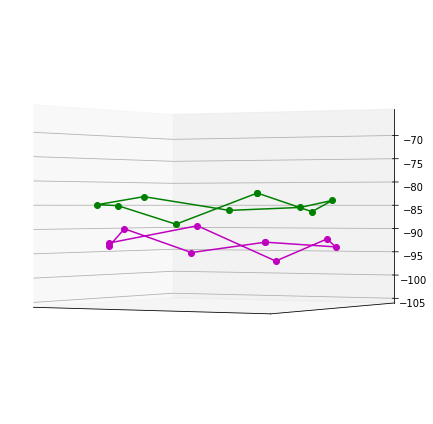

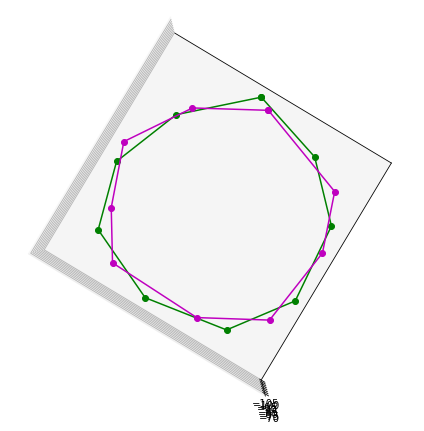

([0, 1, 2, 3, 4, 5, 6, 7, 8], 10.353500253560094) ([0, 1, 2, 3, 4, 5, 6, 7, 8], 11.277373934530797)
6.851665716759314 7.0326218556888875


In [12]:
# 调整前 
plot2ring3D(rotated_back1_real,rotated_back2_real,0)
plot2ring3D(rotated_back1_real,rotated_back2_real,90)
loss1=matrix_loss(mic_data1_b[:2,idx_ls1],real_data1)
loss2=matrix_loss(mic_data2_b[:2,idx_ls2],real_data2)
print(loss1,loss2)
print((max(rotated_back1_real[2,:])-min(rotated_back1_real[2,:])),(max(rotated_back2_real[2,:])-min(rotated_back2_real[2,:])))
plot2ring_and_star(mic_data1_b[:2,idx_ls1],mic_data2_b[:2,idx_ls2],real_data1,real_data2,color_dict,"angle_fix.jpg")

In [13]:
def help_find_mi_rotation(data1,data2,rotate_matrix,real_data1,real_data2):
    global_d1xy_loss=np.inf
    for dx in np.linspace(-5,5,10,endpoint=False):
        for dy in np.linspace(-5,5,10,endpoint=False):
            rdx=dx*PI/180
            rdy=dy*PI/180

            rotate_matrix_rst=rotatexyz(rdx,rdy,0)
            rotated_data1=np.dot(rotate_matrix_rst,data1)
            rotated_data2=np.dot(rotate_matrix_rst,data2)
            
            rotated_mic_data1=np.dot(rotate_matrix,rotated_data1)
            rotated_mic_data2=np.dot(rotate_matrix,rotated_data2)
            
            idx_ls1,loss1=matrix_loss(rotated_mic_data1,real_data1)
            idx_ls2,loss2=matrix_loss(rotated_mic_data2,real_data2)
            
            loss= loss1+ loss2 


            if loss < global_d1xy_loss:
                global_d_want=(dx,dy,rotated_data1,rotated_data2,rotated_mic_data1,rotated_mic_data2,idx_ls1,idx_ls2)
                global_d1xy_loss=loss
    return global_d_want,global_d1xy_loss

In [14]:
global_d_want,global_d1xy_loss=help_find_mi_rotation(data1,data2,rotate_matrix,real_data1,real_data2)

print(global_d1xy_loss)

21.59642471988696


In [15]:
dx,dy,rotated_data1,rotated_data2,roted_mic_data1,roted_mic_data2,idx_ls1,idx_ls2=global_d_want
print(dx,dy)

-1.0 -1.0


hd
7.273401794112345 8.596985539200503
d1:71.34862645478759 ,d2:71.25026356216839 ,dh:-7.778967470692434 ,theta:-13.777777777777779 


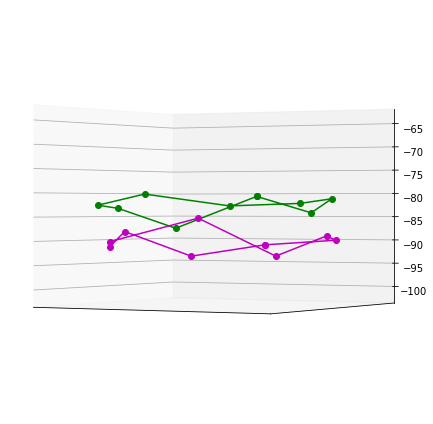

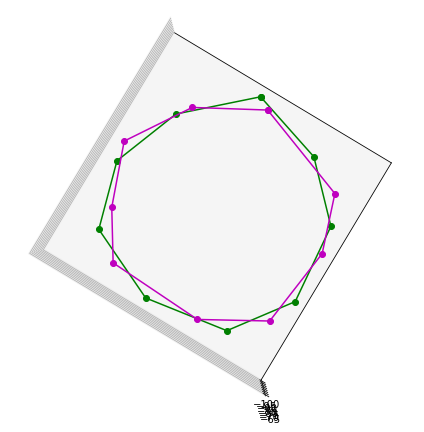

In [16]:
# 用一个面调整后 


rotated_back1_real=reverse_rotation(idx_ls1,roted_mic_data1,real_data1)
rotated_back2_real=reverse_rotation(idx_ls2,roted_mic_data2,real_data2)
print("hd")
print((max(rotated_back1_real[2,:])-min(rotated_back1_real[2,:])),(max(rotated_back2_real[2,:])-min(rotated_back2_real[2,:])))
theta=find_theta(idx_ls1,idx_ls2)
print("d1:{} ,d2:{} ,dh:{} ,theta:{} ".format(d1,d2,dh,theta))
plot2ring3D(rotated_back1_real,rotated_back2_real,0)
plot2ring3D(rotated_back1_real,rotated_back2_real,90)
plot2ring_and_star(roted_mic_data1[:2,idx_ls1],roted_mic_data2[:2,idx_ls2],real_data1,real_data2,color_dict,"angle_fix.jpg")

In [17]:
mean_h1=np.mean(rotated_back1_real[2,:])
mean_h2=np.mean(rotated_back2_real[2,:])

In [18]:
def find_parameter_position(circle_position,real_position,rotation_matrix,hext):

    min_loss=np.inf
    round_num=0
    while(round_num < 1):
        round_num+=1
        N = 100 # 迭代次数
        step = 1 # 初始步长
        epsilon = 0.05
        variables = 3 # 变量数目
        x = [circle_position[0],circle_position[1],hext] # 初始点坐标 xyz
        walk_num = 1 # 初始化随机游走次数
        n = 8 # 每次随机生成向量u的数目
        while(step > epsilon):
            k = 1 # 初始化计数器
            while(k < N):
                x1_list = [] # 存放x1的列表
                for i in range(n):
                    u = [random.uniform(-1,1) for i1 in range(variables)] # 随机向量    
                    u1=[]
                    for i3 in range(variables):
                        temp=0
                        for i2 in range(variables):
                            temp+=u[i2]**2
                        u1.append(u[i3]/ math.sqrt(temp))
                    x1 = update_variable(x,u1,step)
                    x1_list.append(x1)
                f1_list=[]
                for parameter in x1_list:
                    loss=find_loss_position(parameter,rotate_matrix,real_position)
                    f1_list.append(loss)
                f1_min = min(f1_list)
                f1_index = f1_list.index(f1_min)
                x11 = x1_list[f1_index] # 最小f1对应的x1
                if(f1_min < find_loss_position(x,rotate_matrix,real_position)): # 如果找到了更优点
                    k = 1
                    x = x11
                    if f1_min < min_loss: 
                        global_x = x11
                        min_loss=f1_min
                else:
                    k += 1
            step = step* 0.5
            walk_num += 1 
    print("最终最优点:",global_x)
    print("最终最优值:",min_loss)
    return global_x,min_loss

def find_loss_position(parameter,rotate_matrix,real_position):
    localization=np.dot(rotate_matrix,np.array(parameter))
    real_loss=(localization[0]-real_position[0])**2+(localization[1]-real_position[1])**2
    #circle_loss=sum((localization-np.array(parameter))*(localization-np.array(parameter)))
    loss=real_loss
    return loss
def update_variable(x,ul,step):
    new_x_ls=[]
    for idx in range(len(ul)-1):
        new_x_ls.append(x[idx]+step*ul[idx])
    new_x_ls.append(x[-1]+0*step*ul[-1])
    return new_x_ls

In [19]:
rotate_matrix=rotatexyz(rx,ry,rz)
def re_rote_matrix(rotate_matrix,rotated_data,idx_ls,real_data,hext):
    global_ls=[]
    for i in range(9):
        global_x,loss=find_parameter_position(rotated_data[:,idx_ls[i]],real_data[:,i],rotate_matrix,hext)
        global_ls.append(global_x)
    return global_ls

In [20]:
new_localization_ls1=re_rote_matrix(rotate_matrix,rotated_data1,idx_ls1,real_data1,mean_h1)
new_localization_ls2=re_rote_matrix(rotate_matrix,rotated_data2,idx_ls2,real_data2,mean_h2)

最终最优点: [78.24978976897096, 11.394584069460622, -82.72314993159137]
最终最优值: 6.414725813882783e-06
最终最优点: [42.90519285798056, -28.556002679588868, -82.72314993159137]
最终最优值: 1.2744360763881004e-05
最终最优点: [23.699169540568587, -69.68841376359542, -82.72314993159137]
最终最优值: 4.397362764178803e-06
最终最优点: [35.61414859098023, -111.42482204819592, -82.72314993159137]
最终最优值: 2.155313853737422e-05
最终最优点: [81.13018703178216, -131.0983752320795, -82.72314993159137]
最终最优值: 6.82859892635293e-06
最终最优点: [136.72708192044666, -124.53406090921725, -82.72314993159137]
最终最优值: 1.6285712550906812e-05
最终最优点: [163.519556406035, -86.97894577438704, -82.72314993159137]
最终最优值: 8.688269195380961e-06
最终最优点: [157.63163454080663, -35.10969695698783, -82.72314993159137]
最终最优值: 8.637117000171321e-08
最终最优点: [128.62911295038612, -5.3032751432952585, -82.72314993159137]
最终最优值: 5.014558182324742e-06
最终最优点: [88.50287825636947, 6.0679382307110075, -90.13334639543909]
最终最优值: 1.1902275117300256e-05
最终最优点: [48.09020171839833, -18.

In [21]:
new_localization1=np.vstack(new_localization_ls1).T
new_localization2=np.vstack(new_localization_ls2).T

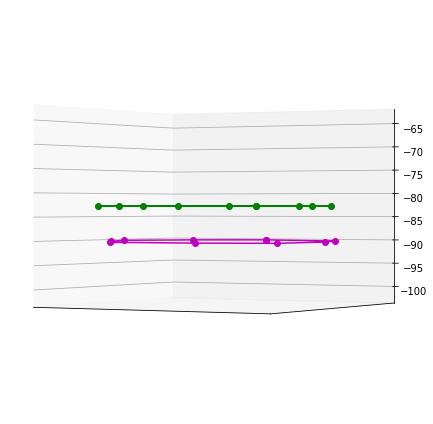

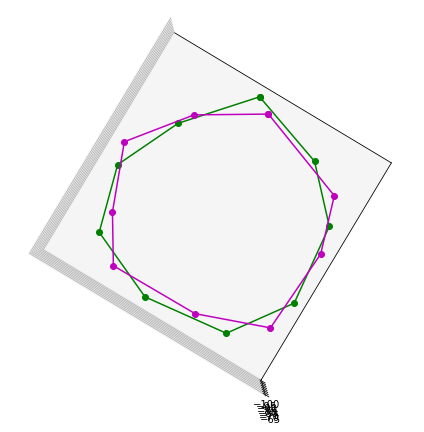

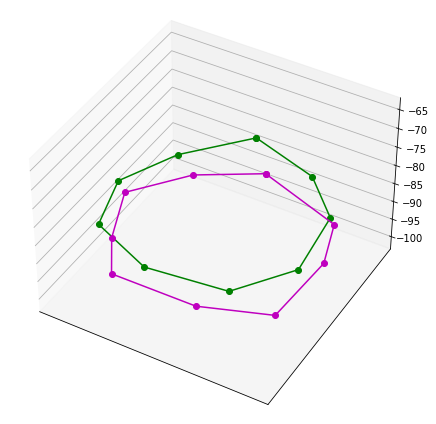

hd
0.0 0.0


In [22]:
plot2ring3D(new_localization1,new_localization2,0)
plot2ring3D(new_localization1,new_localization2,90)
plot2ring3D(new_localization1,new_localization2,40)
print("hd")
print((max(new_localization1[2,:])-min(new_localization1[2,:])),(max(new_localization2[2,:])-min(new_localization2[2,:])))

In [23]:
print("hd")
print((max(rotated_back1_real[2,:])-min(rotated_back1_real[2,:])),(max(rotated_back2_real[2,:])-min(rotated_back2_real[2,:])))
theta=find_theta(idx_ls1,idx_ls2)
print("d1:{} ,d2:{} ,dh:{} ,theta:{} ".format(d1,d2,dh,theta))

hd
7.273401794112345 8.596985539200503
d1:71.34862645478759 ,d2:71.25026356216839 ,dh:-7.778967470692434 ,theta:-13.777777777777779 


In [24]:
mic_data1=np.dot(rotate_matrix,new_localization1,)
mic_data2=np.dot(rotate_matrix,new_localization2,)
loss1=matrix_loss(mic_data1,real_data1)
loss2=matrix_loss(mic_data2,real_data2)
print(loss1,loss2)
plot2ring_and_star(mic_data1[:2,],mic_data2[:2,:],real_data1,real_data2,color_dict,"moved.jpg")

([0, 1, 2, 3, 4, 5, 6, 7, 8], 0.009056108320040583) ([0, 1, 2, 3, 4, 5, 6, 7, 8], 0.0074790786413595715)
